In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import numpy as np
import pandas as pd
pd.set_option('mode.use_inf_as_na', False)

import random

import optuna
optuna.logging.set_verbosity(optuna.logging.WARNING)  
import catboost as cb
import lightgbm as lgb
import xgboost as xgb
from lightgbm import early_stopping, log_evaluation

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    
set_seed(42)

In [3]:
def visualize_data(df1, df2):
    numeric_cols = list(set(df1.select_dtypes(include=['int64', 'float64']).columns) & 
                         set(df2.select_dtypes(include=['int64', 'float64']).columns))
    categorical_cols = list(set(df1.select_dtypes(include=['object', 'category']).columns) & 
                            set(df2.select_dtypes(include=['object', 'category']).columns))
    
    if len(numeric_cols) > 0:
        for col in numeric_cols:
            fig, axes = plt.subplots(2, 2, figsize=(12, 8))
            
            sns.histplot(df1[col], bins=30, kde=True, ax=axes[0, 0], color='blue')
            axes[0, 0].set_title(f'{col} Histogram (Dataset 1)')
            sns.boxplot(x=df1[col], ax=axes[1, 0], color='blue')
            axes[1, 0].set_title(f'{col} Boxplot (Dataset 1)')
            
            sns.histplot(df2[col], bins=30, kde=True, ax=axes[0, 1], color='red')
            axes[0, 1].set_title(f'{col} Histogram (Dataset 2)')
            sns.boxplot(x=df2[col], ax=axes[1, 1], color='red')
            axes[1, 1].set_title(f'{col} Boxplot (Dataset 2)')
            
            plt.tight_layout()
            plt.show()
    else:
        print("No numeric columns!!")
    
    if len(categorical_cols) > 0:
        for col in categorical_cols:
            fig, axes = plt.subplots(1, 2, figsize=(12, 5))
            
            df1[col].value_counts().plot.pie(autopct='%1.1f%%', startangle=90, cmap='Blues', ax=axes[0])
            axes[0].set_ylabel('')
            axes[0].set_title(f'Pie Chart of {col} (Dataset 1)')
            
            df2[col].value_counts().plot.pie(autopct='%1.1f%%', startangle=90, cmap='Reds', ax=axes[1])
            axes[1].set_ylabel('')
            axes[1].set_title(f'Pie Chart of {col} (Dataset 2)')
            
            plt.tight_layout()
            plt.show()
    else:
        print("No categorical columns!!")

In [4]:
def visualize_missing_data(df):
    plt.figure(figsize=(10, 6))
    sns.heatmap(df.isnull(), cmap='gray', cbar=False, yticklabels=False)
    plt.title('Missing Values Heatmap')
    plt.show()

def missing_values_summary(df):
    missing_summary = df.isnull().sum()
    total_values = df.shape[0]
    missing_summary = missing_summary[missing_summary > 0]
    
    if missing_summary.empty:
        print("No missing values in the dataset.")
    else:
        missing_percentage = (missing_summary / total_values) * 100
        missing_df = pd.DataFrame({'Missing Values': missing_summary, 'Percentage': missing_percentage})
        print("Missing values per column:")
        print(missing_df)

In [5]:
def apply_label_encoding(df_1, df_2):
    cat_columns = df_1.select_dtypes(include=['object', 'category']).columns
    num_columns = df_1.select_dtypes(include=['float', 'int']).columns

    for col in cat_columns:
        mode_value = df_2[col].mode()[0] if not df_2[col].mode().empty else None
        df_2[col].fillna(mode_value, inplace=True)

    for col in num_columns:
        median_value = df_2[col].median()
        df_2[col].fillna(median_value, inplace=True)
        
    for col in cat_columns:
        le = LabelEncoder()
        df_1[col] = le.fit_transform(df_1[col])
        df_2[col] = le.transform(df_2[col]) 

    scaler = StandardScaler()
    df_1[num_columns] = scaler.fit_transform(df_1[num_columns])
    df_2[num_columns] = scaler.transform(df_2[num_columns]) 
    
    return df_1, df_2

In [6]:
class XGBoost_Model_Optimizer:
    def __init__(self, n_trials, seed=42, use_gpu=False):
        self.n_trials = n_trials
        self.best_model = None
        self.study = None
        self.seed = seed
        self.use_gpu = use_gpu
        self.model_path = '/kaggle/working/xgb_best_model.json'
        self.rmse_history = []
        np.random.seed(seed)

    def objective_xgb(self, trial, X_train, X_test, y_train, y_test):
        param = {
            'objective': 'reg:squarederror',
            'eval_metric': 'rmse',
            'learning_rate': trial.suggest_float('learning_rate', 1e-4, 0.1, log=True),
            'n_estimators': trial.suggest_int('n_estimators', 100, 500),  
            'max_depth': trial.suggest_int('max_depth', 3, 12),
            'subsample': trial.suggest_float('subsample', 0.6, 1.0),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
            'gamma': trial.suggest_float('gamma', 0, 1),
            'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
            'n_jobs': -1, 
            'random_state': self.seed
        }

        if self.use_gpu:
            param['tree_method'] = 'gpu_hist'  
        else:
            param['tree_method'] = 'hist'  

        model = xgb.XGBRegressor(**param)
        model.fit(X_train, y_train, verbose=False)

        preds = model.predict(X_test)
        rmse = np.sqrt(mean_squared_error(y_test, preds))
        self.rmse_history.append(rmse)
        return rmse

    def train_xgb(self, X_train, X_test, y_train, y_test):
        print("📌 Optimization process started...")
        self.study = optuna.create_study(direction='minimize', sampler=optuna.samplers.TPESampler(seed=self.seed))
        self.study.optimize(lambda trial: self.objective_xgb(trial, X_train, X_test, y_train, y_test), n_trials=self.n_trials)

        best_params = self.study.best_params
        print(f'🏆 Best parameters found: {best_params}')

        self.best_model = xgb.XGBRegressor(**best_params)
        self.best_model.fit(X_train, y_train, verbose=False)

        best_rmse = min(self.rmse_history)        
        self.best_model.save_model(self.model_path)
        print(f'\n💾 Best model saved at -> {self.model_path}')
        print(f'✅ Best RMSE: {best_rmse:.4f}')

    def plt_learning_curve_xgb(self):
        if not self.rmse_history:
            print('❌ You need to train a model first!')
            return

        plt.plot(self.rmse_history, marker='x', linestyle='-')
        plt.xlabel('Trials')
        plt.ylabel('RMSE')
        plt.title('RMSE Learning Curve')
        plt.show()

    def predict_xgb(self, p_data):
        try: 
            pred_model = xgb.XGBRegressor()
            pred_model.load_model(self.model_path)
            return pred_model.predict(p_data)    
        except FileNotFoundError:
            print(f'🚨 Error: Model file "{self.model_path}" not found. You need to train a model first!')
        except Exception as e:
            print(f'⚠️ Unexpected error: {e}')

In [7]:
class CatBoost_Model_Optimizer:
    def __init__(self, n_trials=50, seed=42, use_gpu=False):
        self.n_trials = n_trials
        self.model_path = '/kaggle/working/catboost_best_model.cbm'
        self.seed = seed
        self.use_gpu = use_gpu
        self.best_model = None
        self.study = None
        self.rmse_history = []
        np.random.seed(seed)
    
    def objective_cat(self, trial, X_train, X_test, y_train, y_test):
        params = {
            'depth': trial.suggest_int('depth', 4, 10),
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
            'iterations': trial.suggest_int('iterations', 100, 1000),
            'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1e-3, 10.0, log=True),
            'random_strength': trial.suggest_float('random_strength', 1e-3, 10.0, log=True),
            'border_count': trial.suggest_int('border_count', 32, 255),
            'loss_function': 'RMSE',
            'random_seed': self.seed,
            'verbose': 0
        }

        if self.use_gpu:
            params['task_type'] = 'GPU'
            params['devices'] = '0'  

        model = cb.CatBoostRegressor(**params, early_stopping_rounds=10)
        model.fit(X_train, y_train, eval_set=(X_test, y_test))
        
        preds = model.predict(X_test)
        rmse = np.sqrt(mean_squared_error(y_test, preds))
        self.rmse_history.append(rmse)
        return rmse               
    
    def train_cat(self, X_train, X_test, y_train, y_test):
        print("📌 Optimization process started...")
        self.study = optuna.create_study(direction='minimize', sampler=optuna.samplers.TPESampler(seed=self.seed))
        self.study.optimize(lambda trial: self.objective_cat(trial, X_train, X_test, y_train, y_test), n_trials=self.n_trials)
        
        best_params = self.study.best_params
        print(f'🏆 Best Parameters: {best_params}')
        
        self.best_model = cb.CatBoostRegressor(**best_params)
        self.best_model.fit(X_train, y_train, verbose=False)
        self.best_model.save_model(self.model_path)

        best_rmse = min(self.rmse_history)
        print(f'\n💾 Best model saved at -> {self.model_path}')
        print(f'✅ Best RMSE: {best_rmse:.4f}')

    def plt_learning_curve_cat(self):
        if not self.rmse_history:
            print('❌ You need to train a model first!')
            return

        plt.plot(self.rmse_history, marker='x', linestyle='-')
        plt.xlabel('Trials')
        plt.ylabel('RMSE')
        plt.title('RMSE Learning Curve')
        plt.show()
        
    def predict_cat(self, p_data):
        try: 
            pred_model = cb.CatBoostRegressor()
            pred_model.load_model(self.model_path)
            return pred_model.predict(p_data)    
        except FileNotFoundError:
            print(f'🚨 Error: Model file "{self.model_path}" not found. You need to train a model first!')
        except Exception as e:
            print(f'⚠️ Unexpected error: {e}')


In [8]:
class LightGBM_Model_Optimizer:
    def __init__(self, n_trials=50, seed=42, use_gpu=False):
        self.n_trials = n_trials
        self.model_path = '/kaggle/working/lightgbm_best_model.txt'
        self.seed = seed
        self.use_gpu = use_gpu
        self.best_model = None
        self.study = None
        self.rmse_history = []
        np.random.seed(seed)
    
    def objective_lgb(self, trial, X_train, X_test, y_train, y_test):
        params = {
            'objective': 'regression',
            'metric': 'rmse',
            'boosting_type': 'gbdt',
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
            'num_leaves': trial.suggest_int('num_leaves', 10, 300),
            'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
            'feature_fraction': trial.suggest_float('feature_fraction', 0.5, 1.0),  
            'bagging_fraction': trial.suggest_float('bagging_fraction', 0.5, 1.0),  
            'bagging_freq': trial.suggest_int('bagging_freq', 1, 10),  
            'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
            'verbose': -1
        }

        if self.use_gpu:
            params['device'] = 'gpu'
            params['gpu_platform_id'] = 0
            params['gpu_device_id'] = 0

        model = lgb.LGBMRegressor(**params)
        model.fit(X_train, y_train, eval_set=[(X_test, y_test)])
        
        preds = model.predict(X_test)
        rmse = np.sqrt(mean_squared_error(y_test, preds))
        self.rmse_history.append(rmse)
        return rmse
    
    def train_lgb(self, X_train, X_test, y_train, y_test):
        print("📌 Optimization process started...")
        self.study = optuna.create_study(direction='minimize', sampler=optuna.samplers.TPESampler(seed=self.seed))
        self.study.optimize(lambda trial: self.objective_lgb(trial, X_train, X_test, y_train, y_test), n_trials=self.n_trials)
        
        best_params = self.study.best_params
        print(f'🏆 Best Parameters: {best_params}')
        
        self.best_model = lgb.LGBMRegressor(**best_params)
        self.best_model.fit(X_train, y_train)
        self.best_model.booster_.save_model(self.model_path)

        best_rmse = min(self.rmse_history)
        print(f'\n💾 Best model saved at -> {self.model_path}')
        print(f'✅ Best RMSE: {best_rmse:.4f}')

    def plt_learning_curve_lgb(self):
        if not self.rmse_history:
            print('❌ You need to train a model first!')
            return

        plt.plot(self.rmse_history, marker='x', linestyle='-')
        plt.xlabel('Trials')
        plt.ylabel('RMSE')
        plt.title('RMSE Learning Curve')
        plt.show()
        
    def predict_lgb(self, p_data):
        try: 
            pred_model = lgb.Booster(model_file=self.model_path)
            return pred_model.predict(p_data)    
        except FileNotFoundError:
            print(f'🚨 Error: Model file "{self.model_path}" not found. You need to train a model first!')
        except Exception as e:
            print(f'⚠️ Unexpected error: {e}')


In [9]:
df_train = pd.read_csv("/kaggle/input/playground-series-s5e2/train.csv")
df_test = pd.read_csv("/kaggle/input/playground-series-s5e2/test.csv")
df_train_extra = pd.read_csv("/kaggle/input/playground-series-s5e2/training_extra.csv")

df_train["Laptop Compartment"] = df_train["Laptop Compartment"].astype("category")
df_train_extra["Laptop Compartment"] = df_train_extra["Laptop Compartment"].astype("category")
df_test["Laptop Compartment"] = df_test["Laptop Compartment"].astype("category")

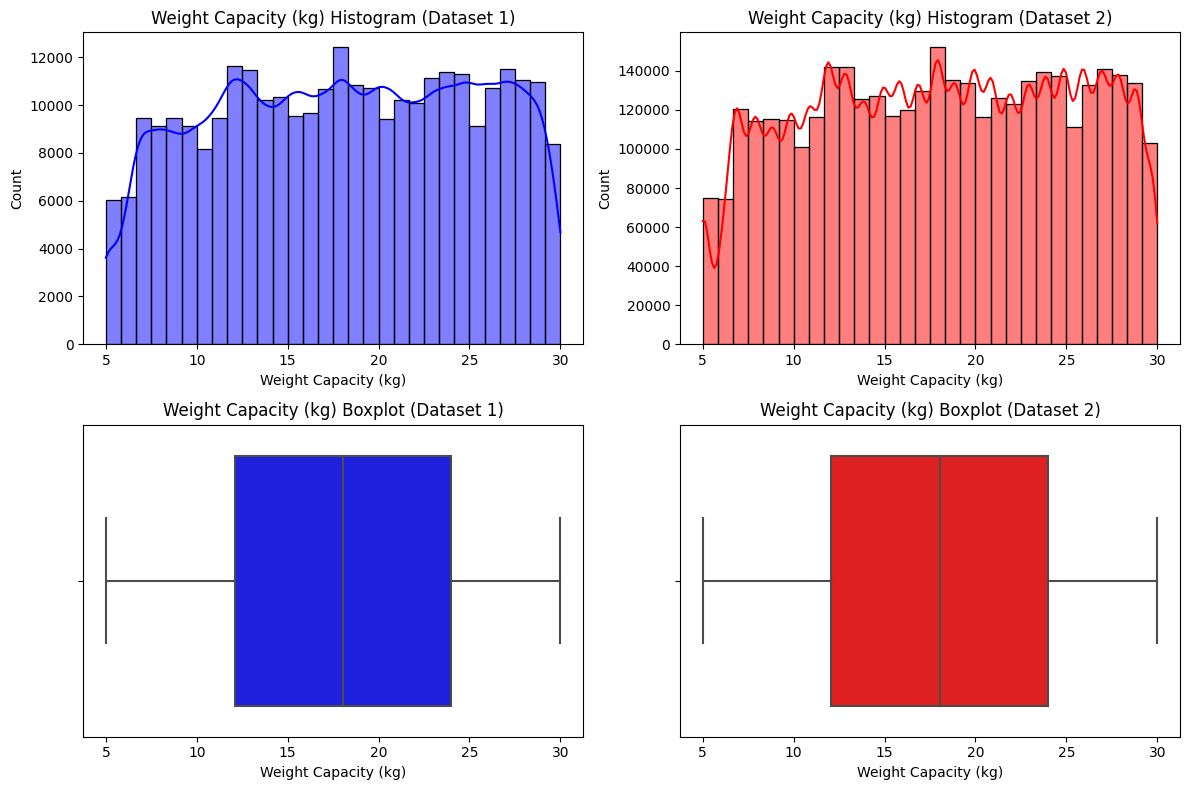

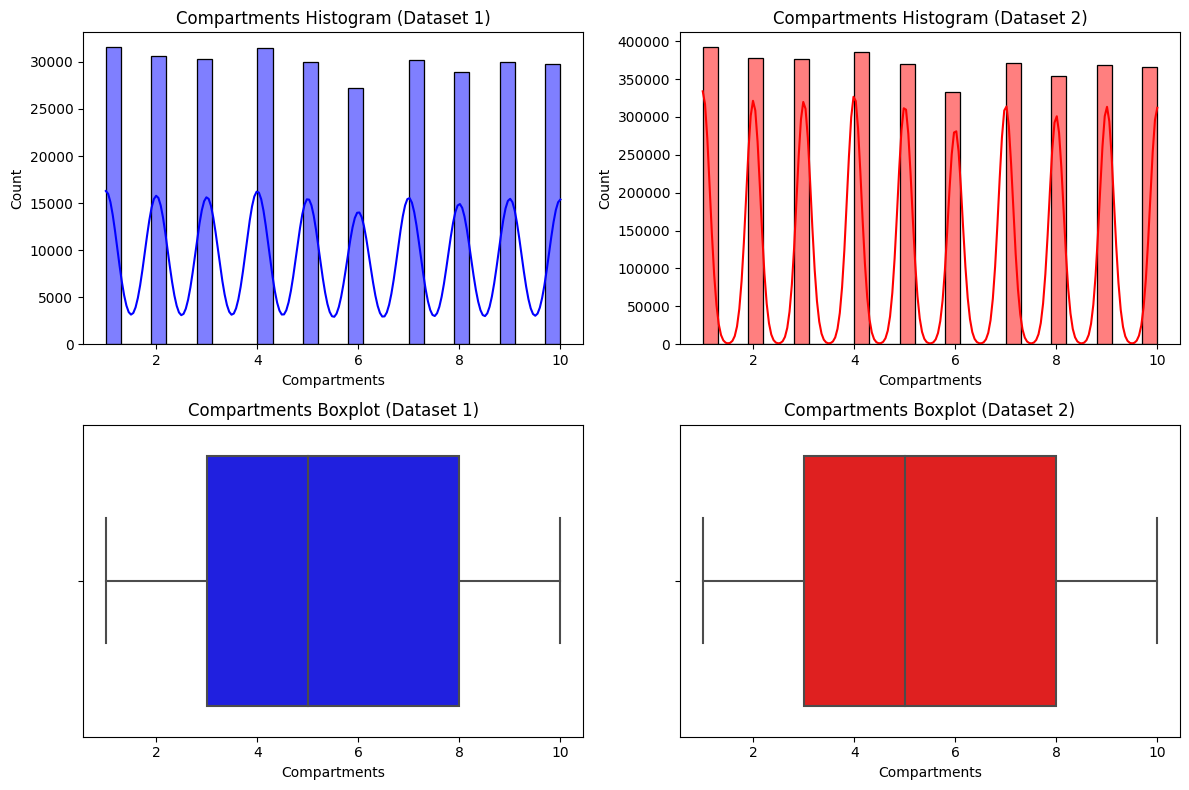

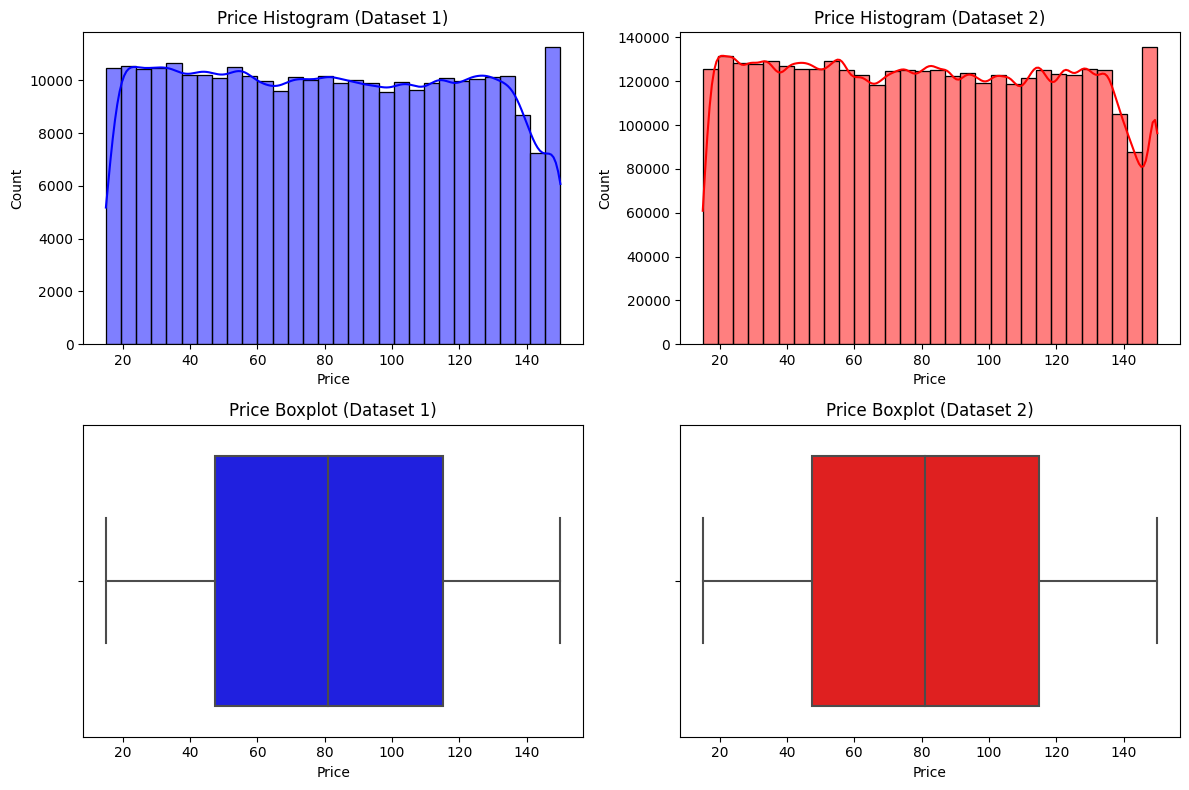

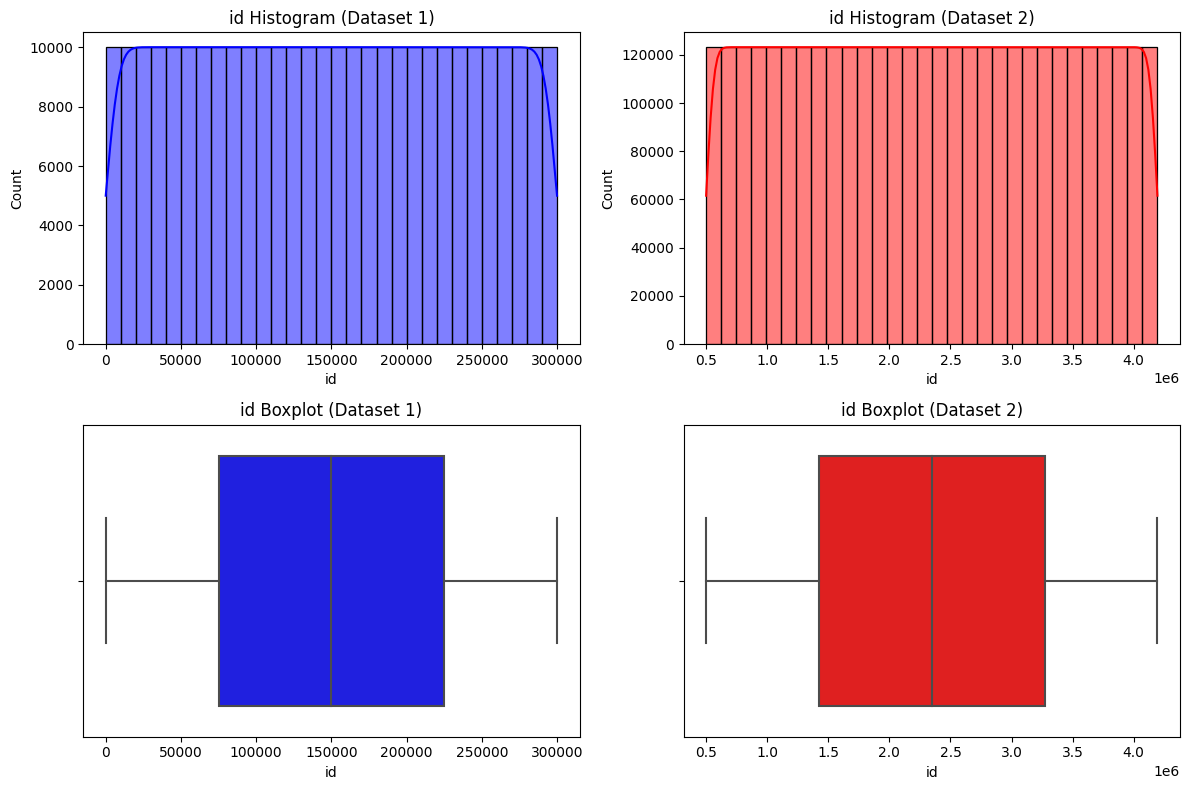

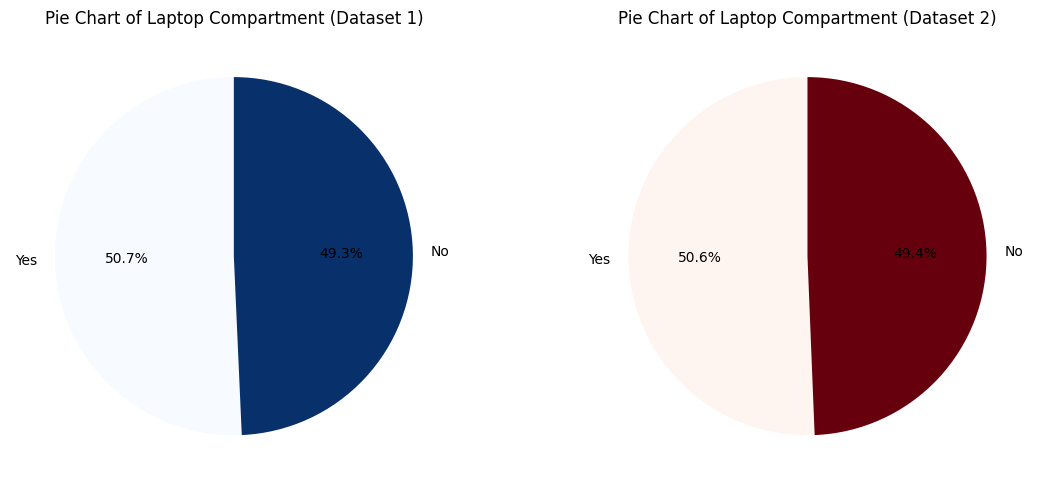

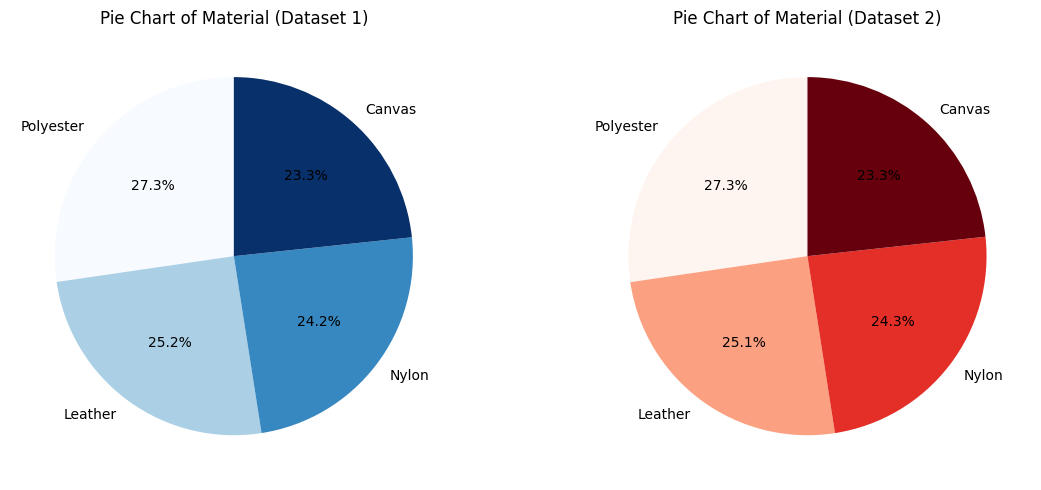

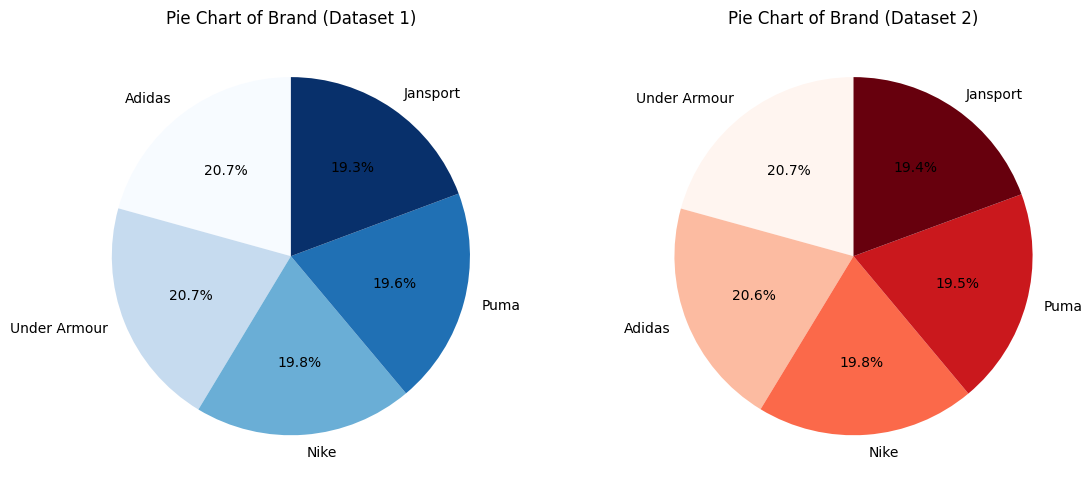

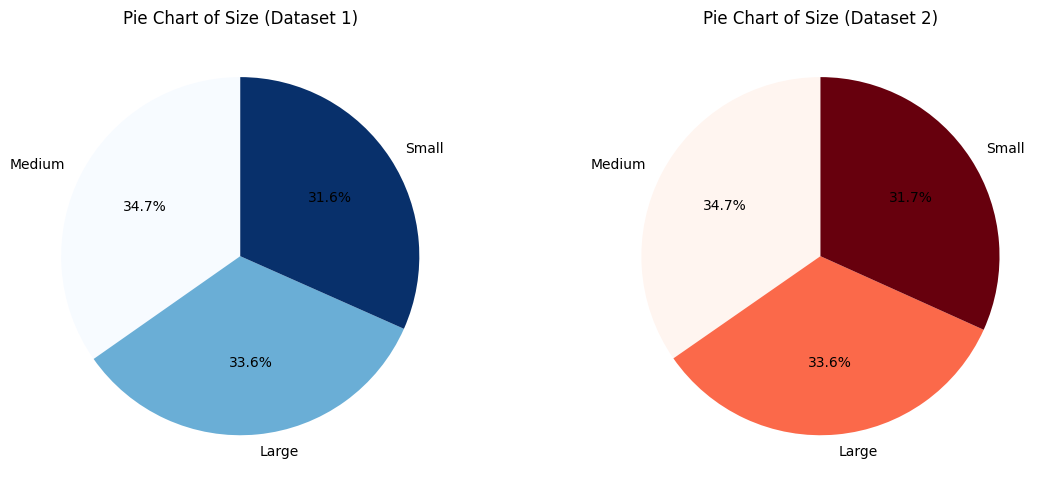

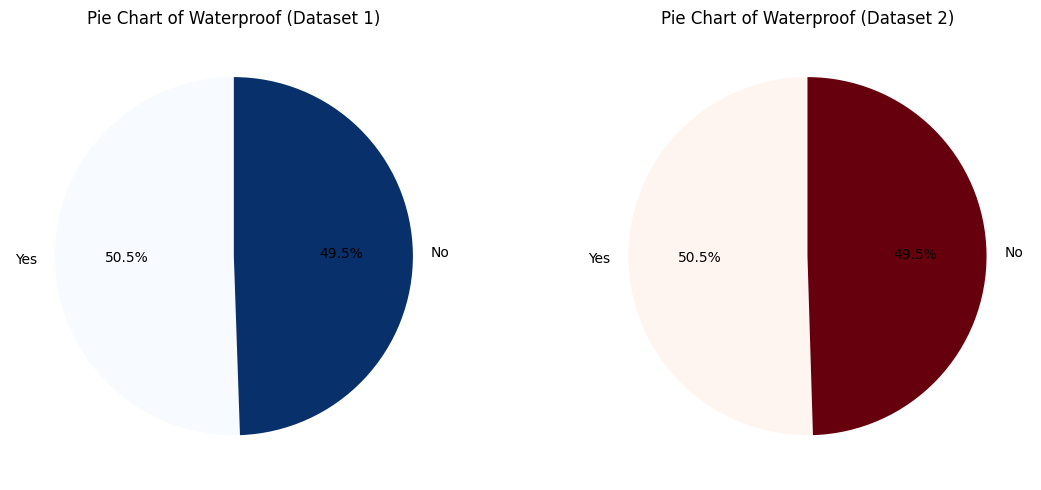

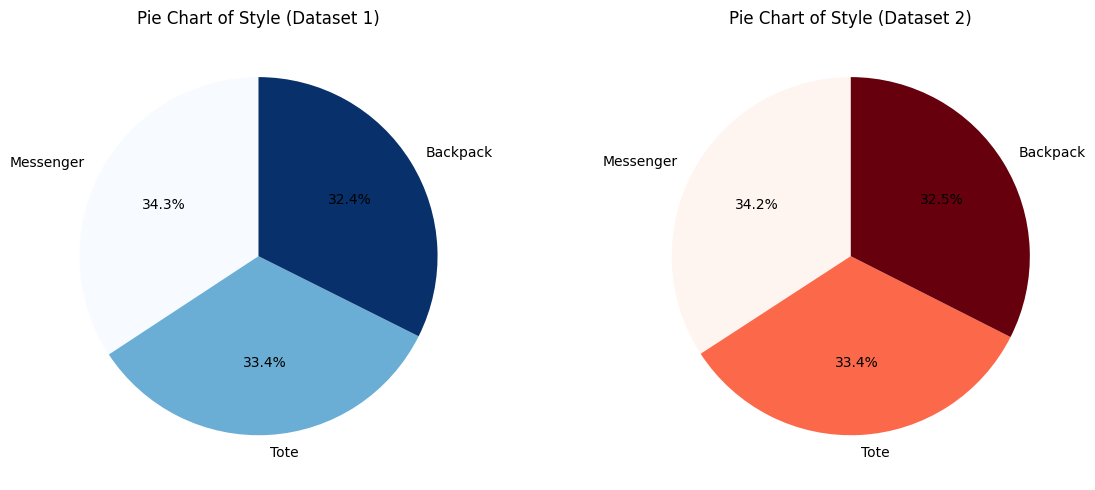

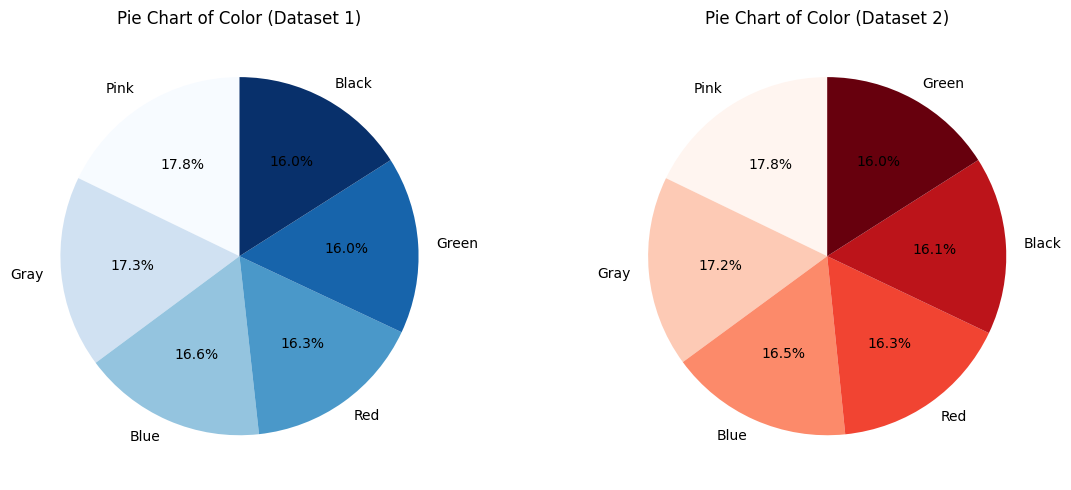

In [10]:
visualize_data(df_train, df_train_extra)

In [11]:
missing_values_summary(df_train)
missing_values_summary(df_train_extra)

Missing values per column:
                      Missing Values  Percentage
Brand                           9705    3.235000
Material                        8347    2.782333
Size                            6595    2.198333
Laptop Compartment              7444    2.481333
Waterproof                      7050    2.350000
Style                           7970    2.656667
Color                           9950    3.316667
Weight Capacity (kg)             138    0.046000
Missing values per column:
                      Missing Values  Percentage
Brand                         117053    3.168460
Material                      102615    2.777644
Size                           81190    2.197699
Laptop Compartment             91089    2.465651
Waterproof                     87274    2.362385
Style                          96210    2.604270
Color                         123667    3.347492
Weight Capacity (kg)            1670    0.045205


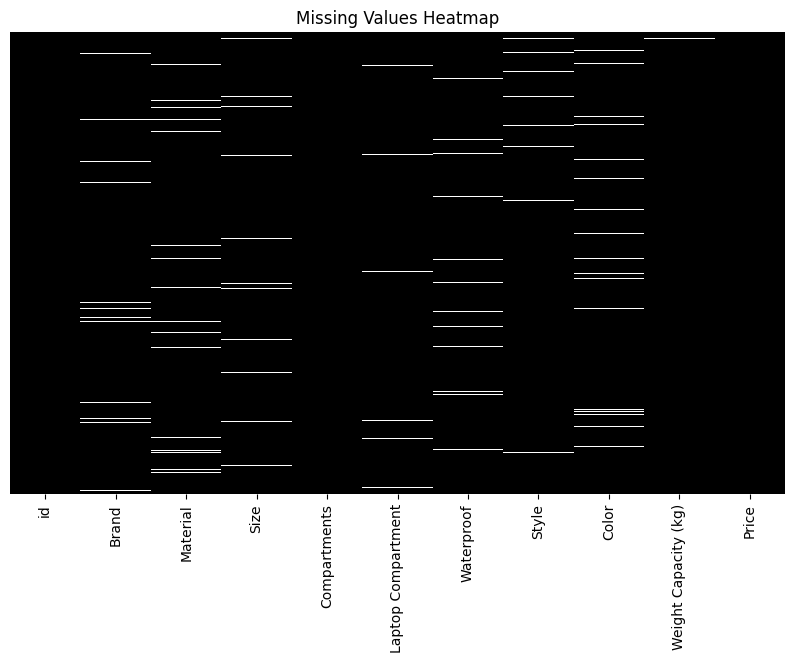

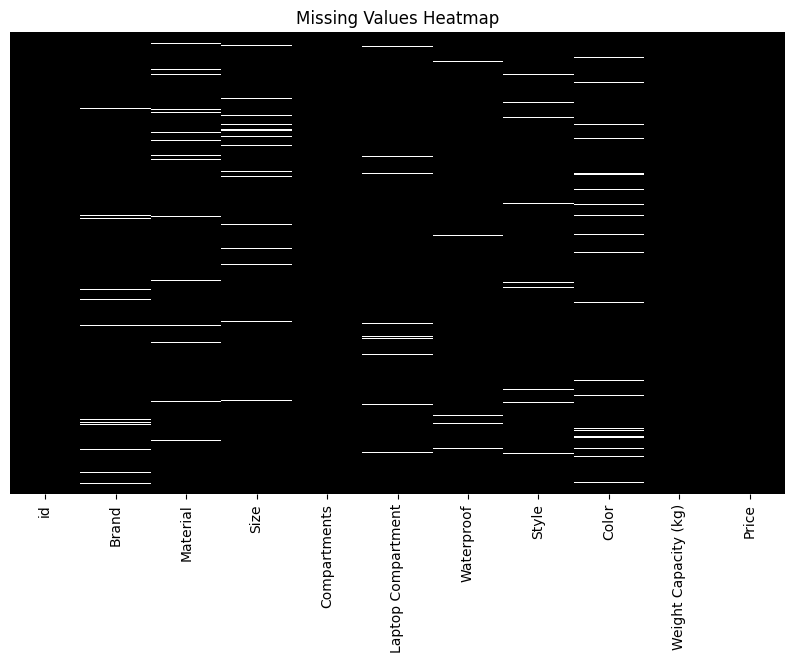

In [12]:
visualize_missing_data(df_train)
visualize_missing_data(df_train_extra)

In [13]:
df_train = df_train.dropna()
df_train_extra = df_train_extra.dropna()
missing_values_summary(df_train)
missing_values_summary(df_train_extra)

No missing values in the dataset.
No missing values in the dataset.


In [14]:
df_tr = pd.concat([df_train, df_train_extra], ignore_index=True)

y = df_tr['Price']
test_id = df_test['id']

df_tr = df_tr.drop(columns=['Price','id'])
df_test = df_test.drop(columns=['id'])

df_train, df_test = apply_label_encoding(df_tr, df_test)

In [15]:
X_train, X_test, y_train, y_test = train_test_split(df_train, y, test_size=0.2, random_state=42)

📌 Optimization process started...
🏆 Best parameters found: {'learning_rate': 0.09798375756127568, 'n_estimators': 450, 'max_depth': 3, 'subsample': 0.9954625633443533, 'colsample_bytree': 0.6493683700479093, 'gamma': 0.29902361176838843, 'min_child_weight': 5}

💾 Best model saved at -> /kaggle/working/xgb_best_model.json
✅ Best RMSE: 38.7684


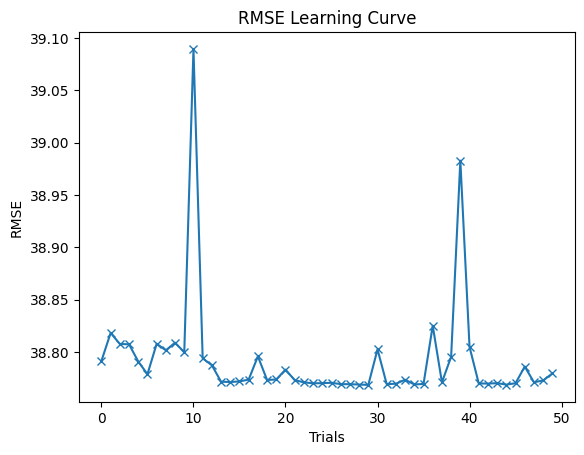

In [16]:
xgb_model = XGBoost_Model_Optimizer(n_trials=50)
xgb_model.train_xgb(X_train, X_test, y_train, y_test)
xgb_model.plt_learning_curve_xgb()

📌 Optimization process started...
🏆 Best Parameters: {'depth': 4, 'learning_rate': 0.21635369438540336, 'iterations': 628, 'l2_leaf_reg': 0.5205880224176938, 'random_strength': 0.12010625924037918, 'border_count': 245}

💾 Best model saved at -> /kaggle/working/catboost_best_model.cbm
✅ Best RMSE: 38.7676


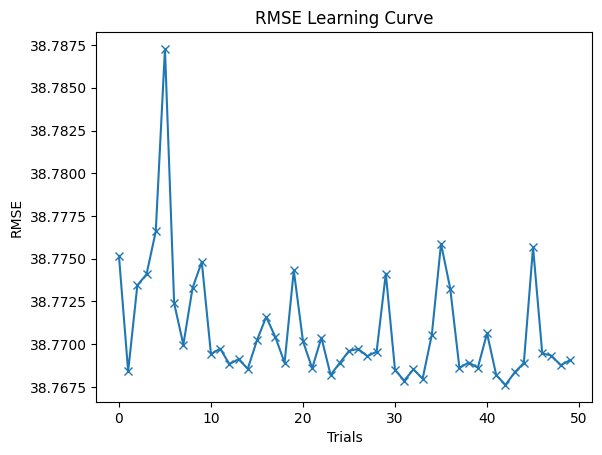

In [17]:
cat_model = CatBoost_Model_Optimizer(n_trials=50)
cat_model.train_cat(X_train, X_test, y_train, y_test)
cat_model.plt_learning_curve_cat()

📌 Optimization process started...
🏆 Best Parameters: {'learning_rate': 0.14862785334391074, 'num_leaves': 14, 'min_child_samples': 87, 'feature_fraction': 0.7815849690546793, 'bagging_fraction': 0.7763230242911485, 'bagging_freq': 10, 'n_estimators': 193}

💾 Best model saved at -> /kaggle/working/lightgbm_best_model.txt
✅ Best RMSE: 38.7677


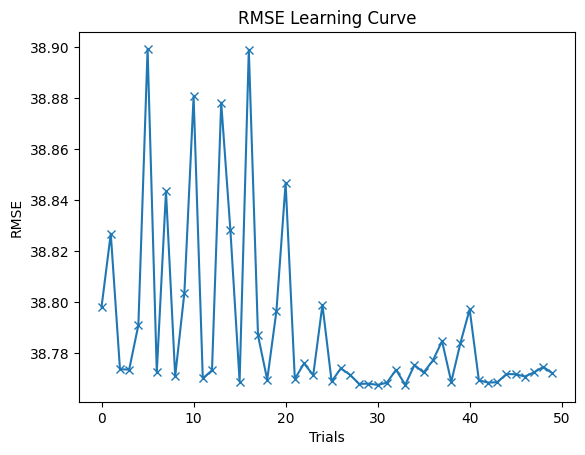

In [18]:
lgb_model = LightGBM_Model_Optimizer(n_trials = 50)
lgb_model.train_lgb(X_train, X_test, y_train, y_test)
lgb_model.plt_learning_curve_lgb()

In [19]:
#predict = xgb_model.predict_xgb(df_test)
prediction = cat_model.predict_cat(df_test)
#lgb_model.predict_lgb(df_test)

In [20]:
prediction

array([79.55156602, 82.60757345, 82.93389617, ..., 83.79120201,
       81.43071385, 80.83105109])

In [21]:
output = pd.DataFrame({
    'Id': test_id, 
    'SalePrice': prediction
})

output

,Id,SalePrice
0,300000,79.551566
1,300001,82.607573
2,300002,82.933896
3,300003,81.470555
4,300004,77.706696
...,...,...
199995,499995,80.170978
199996,499996,74.916197
199997,499997,83.791202
199998,499998,81.430714


In [22]:
output.to_csv('submission.csv', index=False)